In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available

device

'mps'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Skorch can handle PyTorch Datasets directly
X_train, y_train = train_dataset.data.float().unsqueeze(1), train_dataset.targets
X_test, y_test = test_dataset.data.float().unsqueeze(1), test_dataset.targets

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [5]:
# 1. Define your CNN module

class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.fc1   = nn.Linear((channels * 2) * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

In [7]:
net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)
print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0951       0.8752        0.3429  12.3108
      2        0.3177       0.8886        0.3066  12.0724
Train accuracy: 0.9021333333333333


In [8]:
# 3. Wrap model with skorch

net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.001
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

In [40]:
# net.fit(X, y)
# print(net.score(X, y))  # should be far above 10%

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.1000           nan  16.0133
      2           nan       0.1000           nan  16.0808
      3           nan       0.1000           nan  15.7180
      4           nan       0.1000           nan  15.4871
      5           nan       0.1000           nan  15.7791
      6           nan       0.1000           nan  16.5335
      7           nan       0.1000           nan  17.8743
      8           nan       0.1000           nan  15.5864
      9           nan       0.1000           nan  15.1555
     10           nan       0.1000           nan  16.5533
0.1


In [9]:
%%time

# 5B. Faster Randomized Search (params setup)

param_dist = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5]
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
}

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11 µs


In [10]:
%%time

# 5C. Faster Randomized Search (sample combos, actual run;)

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10          # try only 10 random combos
    , cv=2
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

# Fit the randomized search
rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5179       0.8253        0.4754  7.9809
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9853       0.8527        0.4119  7.9728
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7458       0.8540        0.3993  8.4156
      2        0.4619       0.8683        0.3755  6.2478
      2        0.4136       0.8760        0.3476  6.6790
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7385       0.8390        0.4447  10.5289
      2        0.4356       0.8725        0.3514  7.9032
      3        0.3844       0.8747        0.3438  9.0740
      3        0.3400   

      7        0.2825       0.8860        0.3283  869.8183
      4        0.2992       0.8917        0.3174  876.5989
      4        0.2857       0.8933        0.3082  871.6406
      7        0.2409       0.8758        0.3669  846.9198
      8        0.2126       0.9037        0.2749  892.4283
      4        0.2960       0.8847        0.3160  858.5651
      8        0.2442       0.8962        0.2831  868.8709
      4        0.3371       0.8902        0.3074  877.0499
      8        0.2953       0.8902        0.2947  879.1176
      4        0.3582       0.8848        0.3257  880.6994
      8        0.3167       0.8847        0.3140  866.0438
      5        0.3038       0.8983        0.2845  862.6121
      5        0.3036       0.8938        0.2972  865.5965
      5        0.2502       0.8862        0.3186  826.3252
      5        0.2579       0.8887        0.3110  827.8337
      5        0.2810       0.8877        0.3249  831.7866
      5        0.2577       0.8882        0.3166  811.81

      6        0.2154       0.8937        0.3034  6.1855
      6        0.2271       0.8892        0.3132  6.2199
      8        0.2736       0.8918        0.3037  6.3214
      8        0.2588       0.8860        0.3039  6.6237
      7        0.1886       0.8857        0.3462  6.1894
      7        0.2149       0.8897        0.3113  6.1838
      9        0.2580       0.8942        0.2942  6.2891
      9        0.2498       0.8917        0.3004  6.3129
      8        0.1738       0.8938        0.3230  6.3665
      8        0.1934       0.8945        0.3095  6.7532
     10        0.2511       0.8935        0.3032  6.2063
     10        0.2273       0.8935        0.2944  6.2464
      9        0.1573       0.8895        0.3403  6.2511
      9        0.1764       0.8917        0.3256  5.4360
     10        0.1427       0.8940        0.3607  4.8947
     10        0.1682       0.8887        0.3361  5.4514
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -------

In [17]:
# Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,10465.354402,29.579534,214.874824,2.097010,<class 'torch.optim.adam.Adam'>,0.25,32,0.0003,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.375900,0.252033,0.313967,0.061933,10
1,10678.583331,138.980215,224.990696,6.456990,<class 'torch.optim.adam.Adam'>,0.50,32,0.0010,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.264733,0.680433,0.472583,0.207850,9
2,11792.977571,3.769855,207.406576,2.576314,<class 'torch.optim.adam.Adam'>,0.00,32,0.0001,256,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",0.801100,0.689167,0.745133,0.055967,7


In [18]:
results['params'].iloc[0]

{'optimizer': torch.optim.adam.Adam,
 'module__dropout': 0.25,
 'module__channels': 32,
 'lr': 0.0003,
 'batch_size': 256}

In [19]:
rs.best_estimator_

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x1a0490590>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [20]:
best_rand_cv = rs.best_estimator_
best_rand_cv

,module,<class '__main__.SimpleCNN'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x1a0490590>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,10
,batch_size,256
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [34]:
best_rand_cv.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [22]:
# See classes
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
# Predict with best estimator
y_pred = rs.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

acc
print(report)
cm

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.91      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.83      0.85      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.81      0.67      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



array([[883,   1,  16,  11,   3,   0,  80,   0,   6,   0],
       [  1, 984,   2,   8,   2,   0,   2,   0,   1,   0],
       [ 21,   1, 905,   6,  43,   0,  24,   0,   0,   0],
       [ 17,   9,  11, 917,  29,   0,  16,   0,   1,   0],
       [  1,   0,  94,  27, 850,   0,  28,   0,   0,   0],
       [  0,   0,   0,   0,   0, 974,   0,  25,   0,   1],
       [132,   1,  79,  23,  94,   0, 667,   0,   4,   0],
       [  0,   0,   0,   0,   0,   2,   0, 972,   0,  26],
       [  1,   2,   1,   2,   4,   1,   2,   1, 986,   0],
       [  0,   0,   0,   0,   0,   4,   1,  25,   0, 970]])

In [33]:
acc

0.9108

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

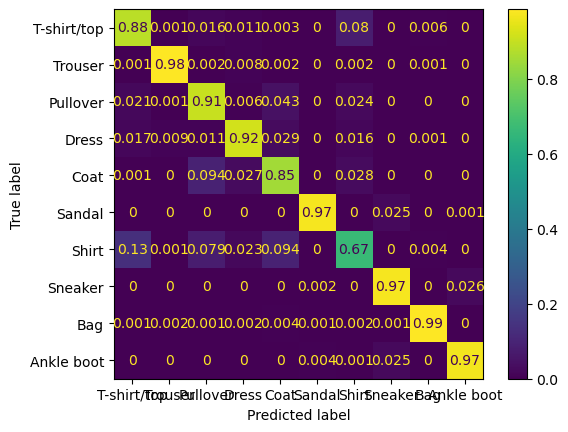

In [32]:
cmp = ConfusionMatrixDisplay.from_estimator(
    rs, X_test, y_test
    , normalize='true'
    , display_labels=class_names
);

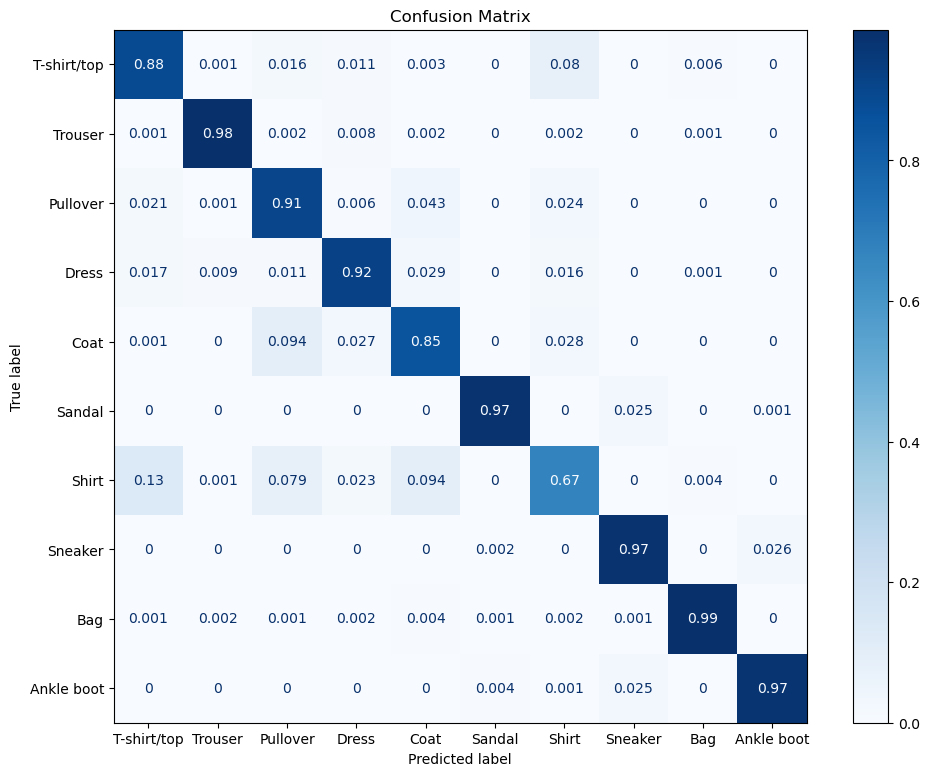

In [31]:
# Create a Matplotlib figure and axes with the desired figsize
fig, ax = plt.subplots(figsize=(12, 9)) # Adjust width and height as needed

# Create a ConfusionMatrixDisplay object (note creating an obj then running the object still outputs a mini cm, which looks strange, so just adding '.plot' to the end of the unnamed obj;)

cmp.plot(ax=ax, cmap='Blues')

# Add a title (optional)
ax.set_title('Confusion Matrix')

# Display the plot
plt.show();

In [37]:
best_rand_cv.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  ),
)>

In [42]:
best_rand_cv.get_params_for_optimizer

TypeError: NeuralNet.get_params_for_optimizer() missing 2 required positional arguments: 'prefix' and 'named_parameters'

In [41]:
# Setup loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=best_rand_cv.get_params_for_optimizer
    , lr=0.0003)

TypeError: 'method' object is not iterable

In [54]:
# 4. Define parameter grid
#    Note: use 'module__' prefix for module args

param_grid = {
    "module__channels": [32, 64]
    , "module__dropout": [0.0, 0.25, 0.5] 
    , "lr": [1e-4, 3e-4, 1e-3]
    , "optimizer": [torch.optim.Adam]
    , "batch_size": [256]
    , "max_epochs": [3]
}

In [61]:
best_net = NeuralNetClassifier(
    module=SimpleCNN
    , criterion=nn.CrossEntropyLoss
    , max_epochs=20
    , lr=0.0003
    , optimizer=torch.optim.Adam
    , batch_size=256
    , iterator_train__shuffle=True
    , device=device
)

best_net.fit(X_train, y_train)
print("Train accuracy:", best_net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.8366       0.8685        0.3710  15.5156
      2        0.3276       0.8840        0.3169  15.5024
      3        0.2766       0.8964        0.2846  16.8444
      4        0.2432       0.9051        0.2634  16.1104
      5        0.2250       0.8996        0.2804  16.0984
      6        0.2091       0.9104        0.2495  16.1239
      7        0.1855       0.9092        0.2460  16.1975
      8        0.1718       0.9107        0.2536  15.7750
      9        0.1641       0.9103        0.2449  15.8042
     10        0.1480       0.9035        0.2779  15.8287
     11        0.1358       0.9100        0.2621  15.6743
     12        0.1285       0.9146        0.2524  15.8504
     13        0.1145       0.9173        0.2499  15.6497
     14        0.1037       0.9168        0.2536  15.6584
     15        0.0999       0.9130        0.2649  15.7950
     16       

In [62]:
best_net.get_params

<bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  ),
)>

In [63]:
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

In [ ]:
"""
# Predict with best estimator
y_pred = grid_search.best_estimator_.predict(
    X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

"""

In [64]:
final_model = NeuralNetClassifier(
    channels=best_params["channels"]
    , dropout=best_params["dropout"]
).to(device)

NameError: name 'best_params' is not defined

In [ ]:
# 5A. Exhaustive Grid Search (slow but complete)
# ---------------------------------------------------------
gs = GridSearchCV(
    estimator=net
    , param_grid=param_grid
    , cv=3               # 3-fold cross validation
    , scoring="accuracy" # use accuracy for FashionMNIST
    , verbose=2
    , n_jobs=-1          # parallelize if possible
)

# Fit the grid search
gs.fit(X, y)

print("Best CV accuracy:", gs.best_score_)
print("Best params:", gs.best_params_)